<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/pitch_contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connects colab to drive
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/AA/Code')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip3 install spleeter

In [ ]:
from spleeter.separator import Separator

# Using embedded configuration.
separator = Separator('spleeter:2stems')

separator.separate_to_file('/content/drive/My Drive/AA/Music dataset/tonic_dataset_og/T. V. Sankaranarayanan - Chakkaniraja.mp3', '/content/drive/My Drive/AA/Music dataset/test_source_sep')

In [2]:
import librosa
import librosa.display
from swipe import *
from scipy import signal
import math
from collections import defaultdict, OrderedDict
import statistics
import copy
import json
import os
plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None): 
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    self.pitch_contour()
    self.constant_pitch()
    self.find_gamaka()
    self.find_stationary_points()
    self.develop_histogram(cpn = True)
    self.tonic = self.find_tonic()
    # self.normalize()
    # self.develop_histogram(cpn = False)
    # self.histogram()
    # self.find_all_notes()
    # self.sequence_notes = self.find_sequence_notes(parameter = self.all_notes)
    # self.pattern=self.find_pattern()
  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
    
  def constant_pitch(self ):
    
    time_axis_80 = []
    pitch_80 = []
    constant_pitch_time_80=[]
  
    for i in range(0,len(self.time_axis),8):
      pitch_80.append(self.pitch[i])
      time_axis_80.append(self.time_axis[i])
    delta = 12
      
    diff_80 = np.diff(pitch_80)

    for i in range(len(diff_80)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(diff_80[i]<delta/2 and diff_80[i]>-delta/2):
        constant_pitch_time_80.append(time_axis_80[i])
    self.constant_pitch_time_80 = np.array(constant_pitch_time_80)

    cpt = list(self.constant_pitch_time_80.round(2))
    tim = []
    initial = cpt[0]
    c= initial
    for i in range(1,len(cpt)):
      check = round(cpt[i]-c,2)
      if(check == 0.08):
        pass
      else:
        tim.append((initial,c))
        initial = cpt[i]
      if i == (len(cpt)-1):
        c= cpt[i]
        tim.append((initial,c))
      c= cpt[i]
    ta = list(self.time_axis)
    self.cpn_and_t = []
    for i in tim:
      begin = int(100*i[0])
      end = int(100*i[1])
      self.cpn_and_t.append((self.pitch[begin:end],ta[begin:end]))
    self.cpn_and_t = np.array(self.cpn_and_t)
    g,h = self.cpn_and_t.T
    self.cpn = np.array([item for sublist in g for item in sublist])
    self.cpt = np.array([item for sublist in h for item in sublist])
  
  def find_all_notes(self):  
    self.all_notes = []
    for i in self.n_pitch:
      if i in self.n_cpn or i in self.n_stp:
        self.all_notes.append(i)

  def find_gamaka(self):
    ta = list(self.time_axis)
    self.bt_cpn = []
    self.bt_cpt = []
    init = 0
    for _,j in self.cpn_and_t:
      if(j):
        begin = int(100*init)
        end = int(100*j[0])
        temp = self.pitch[begin:end]
        self.bt_cpn.append(temp)
        self.bt_cpt.append(ta[begin:end])
        init = j[-1]

  def find_stationary_points(self):
    self.stp = []
    self.stp_t = []
    for i in range(len(self.bt_cpn)):
      test = self.bt_cpn[i]
      test_time  = self.bt_cpt[i]
      for i in signal.find_peaks(test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
      for i in signal.find_peaks(-1*test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
  def develop_histogram(self,cpn):
    if(cpn):
      d = list(self.cpn) + list(self.stp)
      values=[x for x in d if (math.isnan(x) == False)]
      initial = 120
      end = 500
      increment = 1
      r = 0
    else:
      values = [x for x in self.n_pitch if (math.isnan(x) == False)]
      initial = all_normalized_notes['lSa0']
      end = all_normalized_notes['hNi3']
      increment = 0.01
      r = 2
    # values.extend(self.stp)
    values=[round(x,r) for x in values]
    occur=dict()
    self.d_hist=defaultdict(int)
    for i in values:
      if(i in occur):
        occur[i]+=1;
      else:
        occur[i]=1;
    j=initial
    while(j<=end):
      # print(j)
      if(j in occur):
        self.d_hist[j]=occur[j]
        # times.append(occur[j])
      else:
        self.d_hist[j]=0
      j+=increment
      j = round(j,r)

  def find_tonic(self):
    def close_5(arr):
      top5=list()
      for i in arr:
        count=0
        for j in arr:
          if(abs(i-j)<16):
            count+=1
        if (count>len(arr)/2):
          top5.append(i)
      return(top5)
    def toniclist(self) :
      un_notes=[]
      for i in list(self.cpn):
        if(not(np.isnan(i))):
            un_notes.append(round(i,2))
      un_notes.sort()

      occur={}
      hist=defaultdict(int)
      for i in un_notes:
            if(i in occur):
              occur[i]+=1;
            else:
              occur[i]=1;
      # soccur = sorted(occur.items(), key=lambda x: x[1], reverse=True)
      # print("soccur :",soccur )
      # occurvalues=list(occur.values())
      #from collections import OrderedDict 
      # soccur = OrderedDict(sorted(occur.items()))
      self.occur = occur
      self.soccur={k: v for k, v in sorted(occur.items(), key=lambda item: item[1],reverse=True)} 
      # print("soccur :",soccur )
      occurvalues=list(occur.values())
      # occurvalues=[]
      # for i in soccur:
      #   occurvalues.append(i[0])
      indexlist=[]
      for i in range(1,len(occurvalues)-1):
        if((occurvalues[i-1]<occurvalues[i])and(occurvalues[i+1]<occurvalues[i])):
          indexlist.append(i)
      it=0
      toniclist=[]
      for i in occur:
        it+=1
        if(it in indexlist):
          # print(i," : ",occur[i])
          if(i>130):
            toniclist.append(i)
            # print(i," : ",occur[i])
      return_toniclist=sorted(toniclist)
      return_toniclist=toniclist[:50]
      return(return_toniclist)
    
    def remove_outliers(an_array):
      if(len(an_array)<3):
        return(an_array)
      else:  
        mean=statistics.mean(an_array)
        an_array = np.array(an_array)
        # mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 0.9
        not_outlier = distance_from_mean <= 1.1* max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]

        return(no_outliers)
  
    def half_the_Sa(ton):

        if(ton>240):
          return (ton/2)
        else:
          return ton
    Sa_candidates=defaultdict(list)
    self.tonic_candidates=toniclist(self)
    Sa_tonic_candidates=[x for x in self.tonic_candidates if x>110 and x<240]
    # print("Tonic candidates :",tonic_candidates)
    for i in self.tonic_candidates:
      for j in Sa_tonic_candidates :
            if(((i/j)>1.48) and ((i/j) <1.51)):
              Sa_candidates["Pa"].append(half_the_Sa(j))
            # if(((i/j)>1.06) and ((i/j) <1.067)):
            #   Sa_candidates["Ri1"].append(half_the_Sa(j))
            # if(((i/j)>1.19) and ((i/j) <1.21)):
            #   Sa_candidates["Ga2"].append(half_the_Sa(j))
              
            if(((i/j)>1.12) and ((i/j) <1.127) ):
              Sa_candidates["Ri2"].append(half_the_Sa(j))

            # if(((i/j)>1.4) and ((i/j) <1.42) ):
            #   Sa_candidates["Ma2"].append(half_the_Sa(j))
              
            # if(((i/j)>1.31) and ((i/j) <1.34) ):
            #   Sa_candidates["Ma1"].append(half_the_Sa(j))
              
            if(((i/j)>1.23) and ((i/j) <1.27)):
              Sa_candidates["Ga3"].append(half_the_Sa(j))
            # if(((i/j)>1.59) and ((i/j) <1.61)):
            #   Sa_candidates["Da1"].append(half_the_Sa(j))
              
            if(((i/j)>1.86) and ((i/j) <1.91) ):
              Sa_candidates["Ni3"].append(half_the_Sa(j))
            if(((i/j)>1.78) and ((i/j) <1.82) ):
              Sa_candidates["Ni2"].append(half_the_Sa(j))
            if(i>200):  
              if(((i/j)>1.98) and ((i/j) <2.2) ):
                Sa_candidates["High_Sa"].append(half_the_Sa(j))
            # if(j>200):
            #   #Pa
            #   if(((i/j)>0.74) and ((i/j) <0.76) ):
            #     Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
            #   #Da2
            #   if(((i/j)>0.82) and ((i/j) <0.85) ):
            #     Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
            #   #Ma
            #   if(((i/j)>0.65) and ((i/j) <0.68) ):
            #     Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
    print("The Sa_candidates are : ",(Sa_candidates)) 
    self.ratio_sa = Sa_candidates
    for i in Sa_candidates:
      Sa_candidates[i]=remove_outliers(Sa_candidates[i])
    #   Sa_candidates[i]=close_5(Sa_candidates[i])
    print("After remove outliers: ", Sa_candidates)
    if("Pa" in Sa_candidates):
      if(len(Sa_candidates["Pa"])!=0):
            Pa= mean(Sa_candidates["Pa"])
            if("High_Sa" in Sa_candidates):
              if(len(Sa_candidates["High_Sa"])!=0):

                      # if(Pa in Sa_candidates["High_Sa"]):
                      #   High_Sa=Pa
                      # else:
                        High_Sa = mean((Sa_candidates["High_Sa"]))
                        # print("x :",x)
                        # High_Sa=mean(x)

                        if(abs(High_Sa-Pa)<5 ):
                          #and (High_Sa+Pa) != 0
                              prob = High_Sa
                              # print("SAPSPSAPSPASA")
                              return(half_the_Sa(prob))     
                            
    
    for i in Sa_candidates:
      # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
        # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
      if(len(Sa_candidates[i])!=0):
          Sa_candidates[i]=mean(Sa_candidates[i])
          
    

    temp=[i for i in list(Sa_candidates.values()) if(i)]
    # print("Temp :",temp)

    # temp2=remove_outliers(temp)
    # finallist=close_5(temp2)
    finallist=remove_outliers(temp)
    print("finallist: ",finallist)
    self.Sa_candidates = Sa_candidates
    if(not(np.isnan(half_the_Sa(mean(finallist))))):
      # print((half_the_Sa(mean(finallist))))
      return((half_the_Sa(mean(finallist))))

    else:
      print("Tonic not found")
  def histogram(self):
    self.hist_bins,self.hist_y = np.array(list(self.d_hist.items())).T
    self.n_hist_y = self.hist_y/len(self.pitch)

  def normalize(self):
    self.n_pitch = [12*np.log2(i/self.tonic) for i in self.pitch]
    self.n_bt_cpn = []
    self.n_bt_cpn1 = []
    for i in self.bt_cpn:
      self.n_bt_cpn.append([12*np.log2(j/self.tonic) for j in i])
    self.n_stp = [12*np.log2(i/self.tonic) for i in self.stp]
    self.n_cpn = [12*np.log2(i/self.tonic) for i in self.cpn]
  
  def find_sequence_notes(self,parameter):
    # print(parameter)
    notes = []
    for k in parameter:
      # min = 40
      if k in self.n_cpn:
        a = 0.04
      else:
        a = 0.135
      for i,j in all_normalized_notes.items():
        if (math.isclose(j,k,abs_tol= a)):
          notes.append(i)
    # print(notes)
    set_note = []
    initial = notes[0]
    set_note.append(initial)
    for i in range(1,len(notes)):
      if (initial != notes[i]):
        initial = notes[i]
        set_note.append(initial)
    return set_note

  def find_pattern(self):
    def countme(l,sl):
      count =0
      for i in range(0,len(l)):
        a=l[i:i+len(sl)]
        if (a==sl):
          count+=1
      return(count)
    cnt=0
    pattern=dict()
    for sublen in range(3,int(4)):
      for i in range(0,len(self.sequence_notes)-sublen):
        sub = self.sequence_notes[i:i+sublen]
        if(len(set(sub))>1):
          cnt = countme(self.sequence_notes,sub)
          str1=""
          strsub=str1.join(sub)
          if cnt >= (4) and strsub not in pattern:
            pattern[strsub] = cnt
    return pattern

  def plot(self,**kwargs):
    for key,value in kwargs.items():
      if(key=='contour' and value):
        plt.plot(self.time_axis,self.n_pitch,label = 'Pitch Contour')
      if(key == 'cpn' and value):
        plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
        plt.scatter(self.cpt,self.n_cpn,c='0',label = 'Constant Pitch')
      if(key =='stp' and value):
        plt.scatter(self.stp_t,self.n_stp,c='#00FF00',label = 'Stationary Points')
        # plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
      if(key =='histogram' and value):
        plt.plot(self.hist_bins,  self.n_hist_y,label = "histogram")
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


ratios = {'Sa0':1,'Ri1':16/15,'Ri2':9/8,'Ga2':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa0':3/2,'Da1':8/5,
          'Da2':5/3,'Ni2':9/5,'Ni3':15/8,'Sa2':2}
all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)
  all_normalized_notes['l'+i] = 12*np.log2(0.5*j)
  all_normalized_notes['h'+i] = 12*np.log2(2*j)

del all_normalized_notes['lSa2']
del all_normalized_notes['hSa0']
all_normalized_notes = OrderedDict(sorted(all_normalized_notes.items(),key=lambda kv: kv[1]))

139.7717613484224
139.7717613484224
The Sa_candidates are :  defaultdict(<class 'list'>, {'Ri2': [140.4, 142.57, 142.57, 142.57, 143.22, 143.61, 144.13, 144.13, 144.39, 144.39, 145.17, 145.17, 145.7, 145.17, 145.7, 145.7, 146.22, 146.22, 146.49, 146.22, 146.49, 146.89, 146.49, 146.89, 146.89, 147.42, 147.42, 147.82, 148.22, 147.82, 148.22, 148.22, 150.64, 150.64, 151.87, 155.62, 155.62, 156.18, 158.45, 159.17, 159.46, 159.75, 160.61], 'Ga3': [140.4, 140.4, 140.4, 142.57, 143.22, 143.61, 144.13, 144.39, 142.57, 143.22, 143.61, 144.13, 144.39, 145.17, 142.57, 143.22, 143.61, 144.13, 144.39, 145.17, 145.7, 146.22, 146.49, 146.89]})
After remove outliers:  defaultdict(<class 'list'>, {'Ri2': array([143.22, 143.61, 144.13, 144.13, 144.39, 144.39, 145.17, 145.17,
       145.7 , 145.17, 145.7 , 145.7 , 146.22, 146.22, 146.49, 146.22,
       146.49, 146.89, 146.49, 146.89, 146.89, 147.42, 147.42, 147.82,
       148.22, 147.82, 148.22, 148.22, 150.64, 150.64, 151.87]), 'Ga3': array([142.57, 143

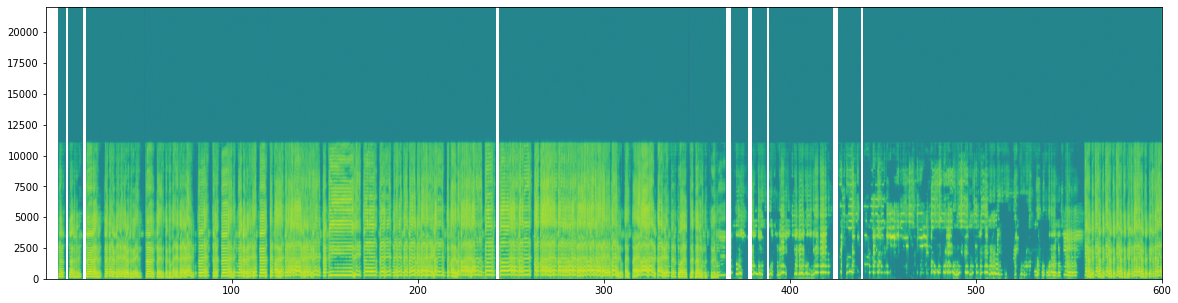

In [ ]:
# test=Audio('/content/drive/My Drive/AA/Music dataset/Tonic_source_separation/ - Shri Lakshmi Varaham/vocals.wav')

In [ ]:
test

In [ ]:
not_working = [' - Anna Purne.mp3', ' - Azhi Mazhai.mp3', ' - Govardana Giridhara.mp3', ' - Janani Ninnuvina.mp3', ' - Jesinadella.mp3', ' - Na Manavini.mp3', ' - Ninnaye.mp3', ' - Santhana Gopalakrishnam.mp3', ' - Sarasadala Nayana.mp3', ' - Sevikkavendum Ayya.mp3', ' - Shri Satyanarayanam.mp3', ' - Simhasanasthithey.mp3', ' - Singara Velavan.mp3', ' - Swaraavali.mp3', ' - Tillana (Nrittaangahaaram).mp3', ' - Vagalaadi.mp3', ' - Vishweshsra.mp3', 'Alathur Brothers - Amba Para Dava.mp3', 'Alathur Brothers - Salamelae - Varnam.mp3', 'Ariyakudi Ramanuja Iyengar - Karuna Samudra.mp3', 'Ariyakudi Ramanuja Iyengar - Koluvaiyunnade.mp3', 'Ariyakudi Ramanuja Iyengar - Nee Bhajana Gana.mp3', 'Ariyakudi Ramanuja Iyengar - Vade Raa.mp3', 'Ariyakudi Ramanuja Iyengar - Yenduku Pedala.mp3', 'Aruna Sairam - Ivela Nannu.mp3', 'Aruna Sairam - Mamavatu Sri.mp3', 'Aruna Sairam - Nadupai.mp3', 'Aruna Sairam - Nittiraiyil.mp3', 'Aruna Sairam - Tatvamariya Tarama.mp3', 'Bombay Jayashri - Deva Deva.mp3', 'Bombay Jayashri - Muruga Muruga.mp3', 'Bombay Jayashri - Ninnu Jeppa.mp3', 'Bombay Jayashri - Sankari Neeve.mp3', 'Bombay Jayashri - Sri Jagadeeswari.mp3', 'Bombay Jayashri - Sri Matrubhutam.mp3', 'D. K. Jayaraman - Chanithodi Theve.mp3', 'D. K. Jayaraman - Karthikeya Kamalekshana Siva.mp3', 'D. K. Jayaraman - Orajoopujoochedi.mp3', 'D. K. Jayaraman - Parvathi Pathim.mp3', 'D. K. Jayaraman - Purahara Nandana.mp3', 'D. K. Jayaraman - Ramanatham.mp3', 'D. K. Jayaraman - Sendhil Aandavan.mp3', 'D. K. Jayaraman - Tharunam Eedamma.mp3', 'D. K. Jayaraman - Theliyaleru Rama.mp3', 'D. K. Pattammal - Vachaspathi - Thani Avarthanam.mp3', 'Dandapani Desikar - Adiyenai Kaattarulvai.mp3', 'Dandapani Desikar - Chilambosai Ketkutamma.mp3', 'Dandapani Desikar - Chinamadaiyaade.mp3', 'Dandapani Desikar - Isaiyin Ellaiyai.mp3', 'Dandapani Desikar - Paadavendume.mp3', 'Dandapani Desikar - Pughazhai Tedi.mp3', 'Dandapani Desikar - Tozhi Idenna.mp3', 'G. N. Balasubramaniam - Brochevarevarura.mp3', 'G. N. Balasubramaniam - Evaramadukudura.mp3', 'G. N. Balasubramaniam - Kalala Nerchina.mp3', 'G. N. Balasubramaniam - Ramachandram.mp3', 'Hyderabad Brothers - Garuda Gamana.mp3', 'Hyderabad Brothers - Govardhana.mp3', 'Hyderabad Brothers - Palinchu Kamakshi.mp3', 'Hyderabad Brothers - Sarasiruha.mp3', 'Hyderabad Brothers - Sobhillu Sapthaswara.mp3', 'K.V. Narayanaswami - Enneramundan.mp3', 'K.V. Narayanaswami - Kana Vendamo.mp3', 'K.V. Narayanaswami - Ninne Namminanu.mp3', 'K.V. Narayanaswami - Pakkala Nilapadi.mp3', 'K.V. Narayanaswami - Samaja Varada Neeku.mp3', 'K.V. Narayanaswami - Sripathe.mp3', 'K.V. Narayanaswami and Dr. N. Ramani - Naadopaasana.mp3', 'M. D. Ramanathan - Alapana.mp3', 'M. D. Ramanathan - Kaddanuvariki.mp3', 'M. D. Ramanathan - Maya Tita Swaroopini.mp3', 'M. D. Ramanathan - Natajanaparipalaya.mp3', 'M. D. Ramanathan - O Jagadamba.mp3', 'M. D. Ramanathan - Srirama Raghurama.mp3', 'M. D. Ramanathan - Varugalamo.mp3', 'M. D. Ramanathan - Vatapi Ganapatim.mp3', 'M. D. Ramanathan - Viribhoni.mp3', 'M.S. Subbulakshmi - Sri Rangapura Vihara.mp3', 'Maharajapuram Santhanam - Bho Sambho.mp3', 'Maharajapuram Santhanam - Dhakshina Murthe.mp3', 'Maharajapuram Santhanam - Madhura Madhura Meenakshi.mp3', 'Maharajapuram Santhanam - Mahaganapathim.mp3', 'Maharajapuram Santhanam - Sankaracharyam.mp3', 'Maharajapuram Santhanam - Vandheham Sharadham.mp3', 'Nedunuri Krishnamurthy - Evarani.mp3', 'Nedunuri Krishnamurthy - Himadrisuthe.mp3', 'Nedunuri Krishnamurthy - Yemaiyyarama.mp3', 'Nithyasree Mahadevan - E endru nan followed by Mamayura Midil.mp3', 'Nithyasree Mahadevan - Nadaloludai.mp3', 'O. S. Thyagarajan - Jagadodharana.mp3', 'R. K. Srikantan - Janani Pahi.mp3', 'S. Ramanathan - Gauri Kalyana.mp3', 'S. Ramanathan - Haarathi.mp3', 'S. Ramanathan - Hecharikaga Rara.mp3', 'S. Ramanathan - Nalungu.mp3', 'S. Ramanathan - Pavvalimpu.mp3', 'S. Ramanathan - Shobaane.mp3', 'S. Ramanathan - Shri Rama Jaya Rama.mp3', 'S. Somasundaram - Nannu Brovu.mp3', 'S. Somasundaram - O Rama Nee Nama.mp3', 'S. Sowmya - Anupama Gunambudhi.mp3', 'S. Sowmya - Diwakara Tanujam.mp3', 'S. Sowmya - Kanda Nal.mp3', 'S. Sowmya - Sarasuda.mp3', 'S. Sowmya - Upacharamu Jese.mp3', 'S. Sowmya - Yarukkahilum.mp3', 'Sanjay Subrahmanyan - Ragam Tanam Pallavi.mp3', 'Sanjay Subrahmanyan - Sri Kamalambikayam.mp3', 'Semmangudi Srinivasa Iyer - Ksheenamai Tiruga.mp3', 'Semmangudi Srinivasa Iyer - Ragam Tanam Pallavi.mp3', 'Sudha Ragunathan - Etti Yochanalu.mp3', 'Sudha Ragunathan - Maalai Varum Velai.mp3', 'Sudha Ragunathan - Pazhani Nindra.mp3', 'Sudha Ragunathan - Raagasudharasa.mp3', 'T. M. Krishna - Adi Nipai.mp3', 'T. Muktha and T. Brinda - Meragadu (Padam).mp3', 'T. Muktha and T. Brinda - Naarimani (Javali).mp3', 'T. Muktha and T. Brinda - Ninnujuchi (Padam).mp3', 'T. Muktha and T. Brinda - Parulanna Mata (Javali).mp3', 'T. Muktha and T. Brinda - Yala Padarevu (Padam).mp3']

In [ ]:
import json
def store_compare_features(audio,name):

    # data={}
    # data['songs'] = []

    # data['songs'].append({ 'song_name': name,
    # 'pattern_data': list(audio.pattern.keys()),
    # 'hist_data': list(audio.n_hist_y),
    # 'gamaka_data':audio.n_bt_cpn1
    # })

    # with open("/content/drive/My Drive/Projects/AA/Audio_data.txt", 'w') as outfile:
    #  json.dump(data, outfile)
    data1={ 'song_name': name,
    'pattern_data': list(audio.pattern.keys()),
    'hist_data': list(audio.n_hist_y),
    'gamaka_data':audio.n_bt_cpn1
    }
    with open("/content/drive/My Drive/Projects/AA/Audio_data.txt", 'r+') as file:
        filedata = json.load(file)
        # filedata.update(data)
        filedata['songs'].append(data1)
        file.seek(0)
        json.dump(filedata, file)

# store_compare_features(kalyani_0,"kalyani_0_song")
store_compare_features(shankarabarana,"Shankarabharana_song")

In [ ]:
def read_compare_features():
  with open("/content/drive/My Drive/Projects/AA/Audio_data.txt",'r+') as json_file:
    data = json.load(json_file)
    print(data['songs'])
    for p in data['songs']:
        if(bool(p)):
          print('Name: ' + p['song_name'])
          #can do any manipulation here

read_compare_features()    

[{'song_name': 'kalyani_0_song', 'pattern_data': [], 'hist_data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
def delete_song_data(name):
   with open("/content/drive/My Drive/Projects/AA/Audio_data.txt") as read_json_file: 
      
    # read data line by line  
    data = json.load(read_json_file)
      
# open file in write mode 
   with open("/content/drive/My Drive/Projects/AA/Audio_data.txt", "w") as write_json_file: 
        for p in data['songs']:
           if(p['song_name']==name):
             print("hi")
             p.clear()
          # print(p['song_name'])
        print(data)
        json.dump(data, write_json_file)    
delete_song_data("Shankarabharana_song") 

hi
{'songs': [{}, {'song_name': 'kalyani_0_song', 'pattern_data': [], 'hist_data': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
class Compare_Audio:

  def __init__(self,audio1,audio2):
    self.audio1=audio1
    self.audio2=audio2
    self.compare_tonic()
    self.compare_pattern()
    self.compare_histogram()
    # self.compare_gamaka()
    self.find_similarity_index()       

    # self.index = 0.1*((audio1.tonic -audio2.tonic)**2)+ 0.3*()

  def compare_tonic(self):
    normalizing_tonic_factor=90
    self.tonic_index=1-(abs(self.audio1.tonic - self.audio2.tonic))/normalizing_tonic_factor

    self.tonic_index

  def compare_pattern(self):
    compare1= list(self.audio1.pattern.keys())
    compare2= list(self.audio2.pattern.keys())

    unnormalized_ratio=0

    for i in compare1:
      if (i in compare2):
        unnormalized_ratio += 1
    self.pattern_index = (unnormalized_ratio)/(min(len(compare1),len(compare2)))


  def compare_histogram(self):
    self.histogram_index = np.corrcoef([self.audio1.n_hist_y,self.audio2.n_hist_y])[0][1]
  def compare_gamaka(self):
    # ff = []
    # for i in self.audio1.n_bt_cpn:
    #   t = stats.zscore([x for x in i if (math.isnan(x) == False)])
    #   gg = []
    #   for j in self.audio2.n_bt_cpn:
    #     tt = stats.zscore([x for x in j if (math.isnan(x) == False)])
    #     gg.append(dtw.distance(t,tt))
    #   ff.append(min(gg))
    # self.gamaka_index = mean(ff)

  def find_similarity_index(self):
    self.similarity_index = (0.4*self.tonic_index + 10*self.pattern_index + 10*self.histogram_index )/10.4


In [ ]:
# shankarabarana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')
# kalyani_1 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav')
# kalyani_2 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav')
# kalyani_0 = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_0.wav')
# abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/seq_test/abhogi.mp3')
# kambhoji = Audio('/content/drive/My Drive/Projects/AA/Music dataset/seq_test/kambhoji.mp3')
# mayamalavagowlai= Audio('/content/drive/My Drive/Projects/AA/Music dataset/seq_test/mayamalavagowlai.mp3')
# shanmukhapriya = Audio('/content/drive/My Drive/Projects/AA/Music dataset/seq_test/shanmukhapriya.mp3')
trichur_kalyani = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/trichur_kalyani.mp3')

In [ ]:
song_array =[vignesh_kalyani,vignesh_sahana,sreevidya_begada,sreevidya_saveri,sreevidya_sahana,sreeevidya_abhogi,dharini_abhogi,dharini_saveri,dharini_mohana,dharini_sahana,vignesh_shree,vignesh_abhogi,vignesh_begada,rkm_abhogi,rkm_kalyani,rkm_mohana,rkm_sahana,rkm_saveri,rkm_shree,badri_kalyani,badri_mohana,badri_saveri,badri_shree,prasanna_kalyani,prasanna_abhogi,prasanna_begada,prasanna_savveri,prasanna_mohana]

In [ ]:
for i in song_array:
  store_compare_features(i,"Shankarabharana_song")


The Sa_candidates are :  defaultdict(<class 'list'>, {'Ga3': [163.24, 163.24, 163.24, 163.24, 166.22, 163.24, 166.22, 163.24, 166.22, 166.97, 167.27, 163.24, 166.22, 166.97, 167.27, 166.22, 166.97, 167.27, 166.22, 166.97, 167.27, 168.94, 166.22, 166.97, 167.27, 168.94, 170.16, 166.22, 166.97, 167.27, 168.94, 170.16, 166.97, 167.27, 168.94, 170.16, 168.94, 170.16, 170.16, 196.78, 197.31, 199.64, 200.36, 200.9, 202.36, 199.64, 200.36, 200.9, 202.36, 203.46, 204.56, 204.93, 199.64, 200.36, 200.9, 202.36, 203.46, 204.56, 204.93, 200.36, 200.9, 202.36, 203.46, 204.56, 204.93, 206.05, 202.36, 203.46, 204.56, 204.93, 206.05, 206.79, 202.36, 203.46, 204.56, 204.93, 206.05, 206.79, 207.73, 203.46, 204.56, 204.93, 206.05, 206.79, 207.73, 208.67, 203.46, 204.56, 204.93, 206.05, 206.79, 207.73, 208.67, 203.46, 204.56, 204.93, 206.05, 206.79, 207.73, 208.67, 209.61, 204.56, 204.93, 206.05, 206.79, 207.73, 208.67, 209.61, 204.56, 204.93, 206.05, 206.79, 207.73, 208.67, 209.61, 210.56, 206.05, 206.79

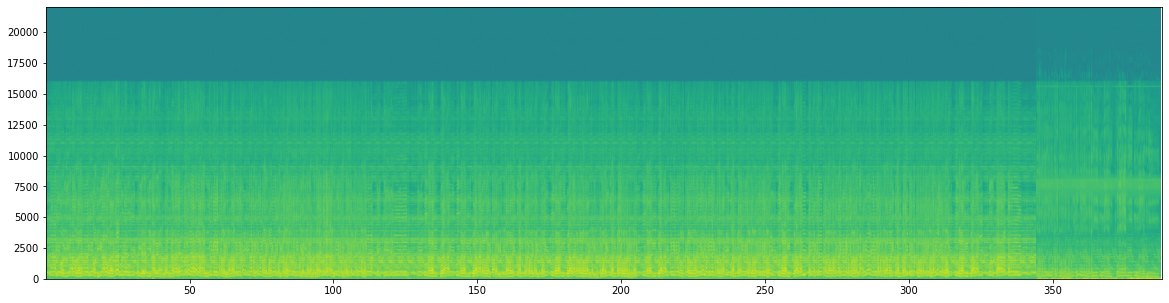

In [28]:
# rkm_abhogi=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')
# rkm_kalyani=Audio('/content/drive/My Drive/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3')
# rkm_mohana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3')
# rkm_sahana=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223595__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sahana-raaga.mp3')
# rkm_saveri=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223601__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-saveri-raaga.mp3')
# rkm_shree=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223604__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-sri-raaga.mp3')
badri_kalyani = Audio('/content/drive/My Drive/AA/Music dataset/Audio/223586__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-kalyani-raaga.mp3')
# badri_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223590__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-mohanam-raaga.mp3')
# badri_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223598__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-saveri-raaga.mp3")
# badri_shree = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223603__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-sri-raaga.mp3")
prasanna_kalyani = Audio('/content/drive/My Drive/AA/Music dataset/Audio/223587__gopalkoduri__carnatic-varnam-by-prasanna-in-kalyani-raaga.mp3')
# prasanna_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223579__gopalkoduri__carnatic-varnam-by-prasanna-in-abhogi-raaga.mp3')
# prasanna_begada = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223583__gopalkoduri__carnatic-varnam-by-prasanna-in-begada-raaga.mp3')
# prasanna_savveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223600__gopalkoduri__carnatic-varnam-by-prasanna-in-saveri-raaga.mp3")
# prasanna_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223592__gopalkoduri__carnatic-varnam-by-prasanna-in-mohanam-raaga.mp3')
# vignesh_kalyani= Audio('/content/drive/My Drive/AA/Music dataset/Audio/223589__gopalkoduri__carnatic-varnam-by-vignesh-in-kalyani-raaga.mp3')
# vignesh_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223582__gopalkoduri__carnatic-varnam-by-vignesh-in-abhogi-raaga.mp3')
# vignesh_begada = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223585__gopalkoduri__carnatic-varnam-by-vignesh-in-begada-raaga.mp3')
# vignesh_sahana = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223597__gopalkoduri__carnatic-varnam-by-vignesh-in-sahana-raaga.mp3")
# vignesh_shree = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223605__gopalkoduri__carnatic-varnam-by-vignesh-in-sri-raaga.mp3")
# dharini_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223578__gopalkoduri__carnatic-varnam-by-dharini-in-abhogi-raaga.mp3')
# dharini_sahana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223594__gopalkoduri__carnatic-varnam-by-dharini-in-sahana-raaga.mp3')
# dharini_mohana = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223591__gopalkoduri__carnatic-varnam-by-dharini-in-mohanam-raaga.mp3')
# dharini_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223599__gopalkoduri__carnatic-varnam-by-dharini-in-saveri-raaga.mp3")
# sreeevidya_abhogi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223581__gopalkoduri__carnatic-varnam-by-sreevidya-in-abhogi-raaga.mp3')
# sreevidya_begada = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223584__gopalkoduri__carnatic-varnam-by-sreevidya-in-begada-raaga.mp3")
# sreevidya_sahana = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223596__gopalkoduri__carnatic-varnam-by-sreevidya-in-sahana-raaga.mp3")
# sreevidya_saveri = Audio("/content/drive/My Drive/Projects/AA/Music dataset/Audio/223602__gopalkoduri__carnatic-varnam-by-sreevidya-in-saveri-raaga.mp3")

In [4]:
def normalize_stp (tonic,obj):
  n_bt_cpn = []
  for i in obj.bt_cpn:
    n_bt_cpn.append([12*np.log2(j/tonic) for j in i])
  return n_bt_cpn

In [29]:
n_bt_cpn_rkm = normalize_stp(149,rkm_kalyani)
n_bt_cpn_vig = normalize_stp(138,vignesh_kalyani)
n_bt_cpn_bad = normalize_stp(138,badri_kalyani)
n_bt_cpn_pras = normalize_stp(146,prasanna_kalyani)

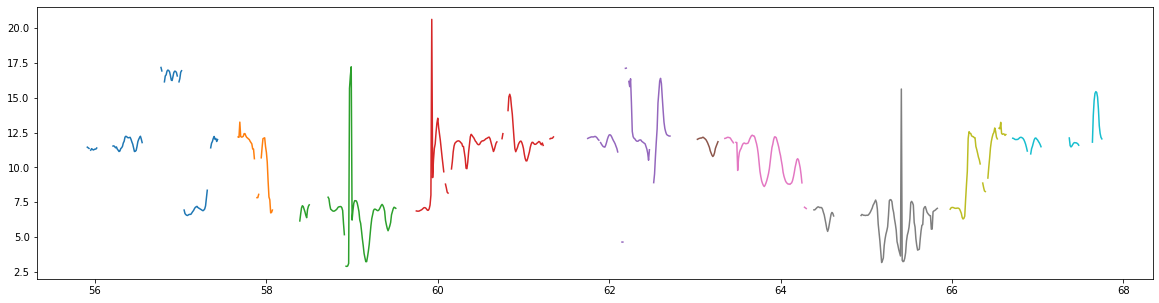

In [45]:
for i in range(50,60):
  plt.plot(rkm_kalyani.bt_cpt[i],n_bt_cpn_rkm[i])

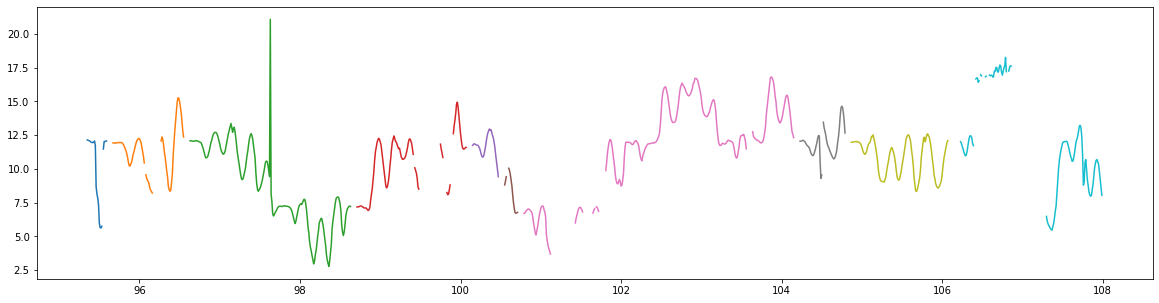

In [40]:
for i in range(90,100):
  plt.plot(vignesh_kalyani.bt_cpt[i],n_bt_cpn_vig[i])

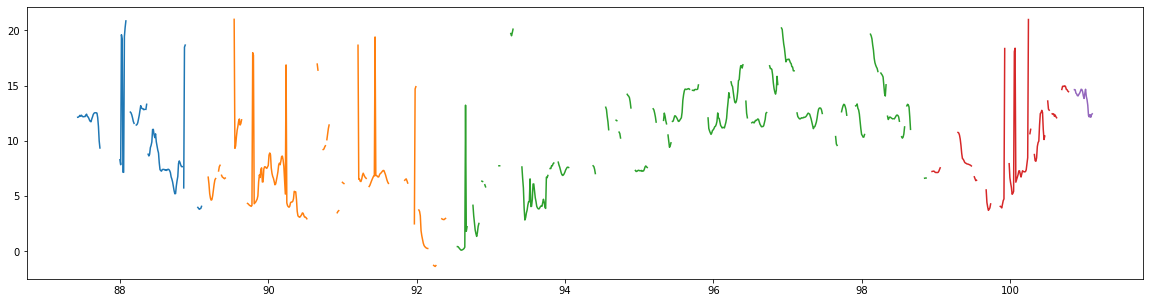

In [41]:
for i in range(70,75):
  plt.plot(prasanna_kalyani.bt_cpt[i],n_bt_cpn_pras[i])

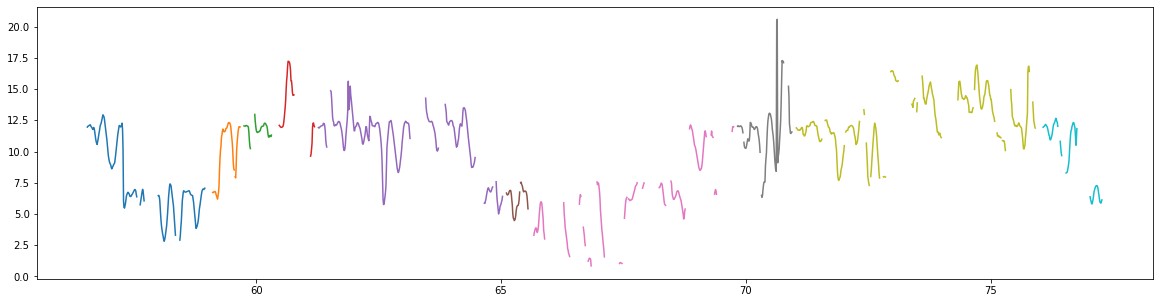

In [49]:
for i in range(30,40):
  plt.plot(badri_kalyani.bt_cpt[i],n_bt_cpn_bad[i])

In [ ]:
important_key = ['n_pitch','time_axis','n_bt_cpn1','tonic','hist_bins','n_hist_y','all_notes','sequence_notes','pattern']
def save_features(audio_clip,filename):
  srt = dict()
  for i in important_key:
    x = audio_clip.__dict__[i]
    if type(x) == type(np.array([])):
      x = list(x)
    srt[i] = x
  json_dump = json.dumps(srt)
  with open("/content/drive/My Drive/Projects/AA/Features/{}.json".format(filename), "w") as outfile: 
      outfile.write(json_dump) 

In [ ]:
save_features(trichur_kalyani,"trichur_kalyani")

In [ ]:
import scipy.stats
from scipy.spatial import distance as dist

def chi2_distance(histA, histB, eps = 1e-10):
  # compute the chi-squared distance
  d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
    for (a, b) in zip(histA, histB)])
  # return the chi-squared distance
  return d

def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance
def euclidean_distance(x,y):
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

In [ ]:
values_1 = [ x for x in rkm_kalyani.n_bt_cpn[0] if math.isnan(x) == False]
values_2 = [x for x in shankarabarana.n_bt_cpn[1] if math.isnan(x) == False]

In [ ]:
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [ ]:
dtw(values_1,values_2)[-1][-1]

102.20312500000307

In [ ]:
!pip install similaritymeasures


     |████████████████████████████████| 399kB 8.7MB/s 
  Created wheel for similaritymeasures: filename=similaritymeasures-0.4.3-cp36-none-any.whl size=14511 sha256=6f843a68741175f5f4520ea87fe9a1b6d37059d460ce3edd81fe45be7566280a
  Stored in directory: /root/.cache/pip/wheels/6f/47/91/f1b5bc17659d9cb15129a6894da6e8950bc01bc21cfb65c2aa
Successfully built similaritymeasures


In [ ]:
from scipy import stats
az = stats.zscore([1,2,3])

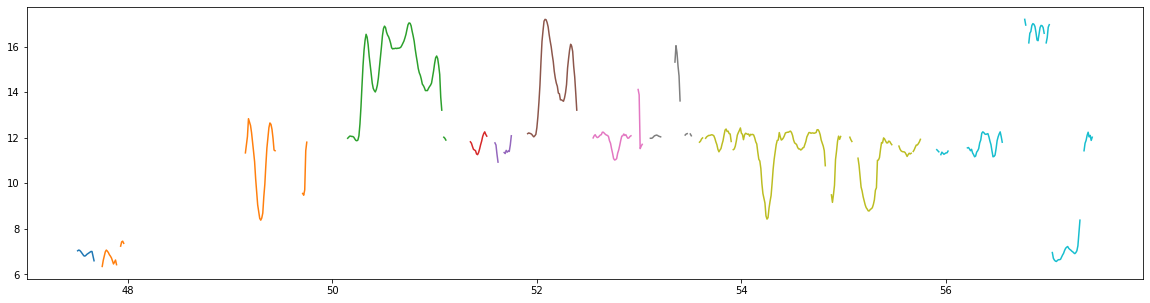

In [ ]:
for i in range(40,50):
  plt.plot(rkm_kalyani.bt_cpt1[i],rkm_kalyani.n_bt_cpn1[i])

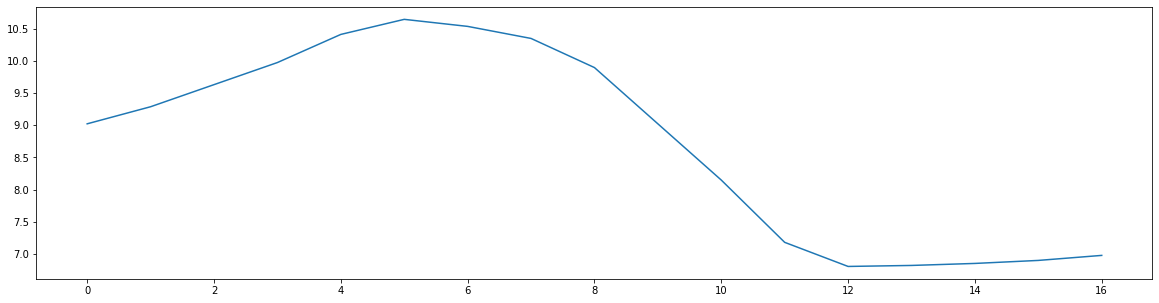

In [ ]:
plt.plot(rkm_kalyani.n_bt_cpn[8])

In [ ]:
import similaritymeasures

In [ ]:
df = similaritymeasures.frechet_dist(rkm_kalyani.n_bt_cpn1[7],rkm_kalyani.n_bt_cpn1[8])
df

2.4687500000000644

In [ ]:
ff = []

In [ ]:
for i in rkm_kalyani.n_bt_cpn1:
    t = [x for x in i if (math.isnan(x) == False)]
    gg = []
    for j in rkm_kalyani.n_bt_cpn1:
      tt = [x for x in j if (math.isnan(x) == False)]
      gg.append(similaritymeasures.frechet_dist(t,tt))
    ff.append(min(gg))
gamaka_index = mean(ff)

In [ ]:
all_songs = os.listdir("drive/My Drive/AA/Music dataset/Tonic_source_separation")
all_songs.remove('.ipynb_checkpoints')
all_songs.sort()
path = "/content/drive/My Drive/AA/Music dataset/Tonic_source_separation/{songname}/vocals.wav"
f= open("/content/drive/My Drive/AA/Music dataset/compMusicDetails.json",)
compMusicTonicDetails = json.load(f)
f.close()
# with open("/content/drive/My Drive/AA/Music dataset/tonic_candi_1.txt","r+") as working_file:
#   working = working_file.read().split('\n')
# finished_file = open("/content/drive/My Drive/AA/Music dataset/tonic_candi_finish_1.txt","r+")

# finished = finished_file.read().split('\n')
# working_file.close()
# finished_file.close()
with open("/content/drive/My Drive/AA/Music dataset/our_tonic_beta.json",) as x:
  ourTonic = json.load(x)
#   pass
# x.close()
with open("/content/drive/My Drive/AA/Music dataset/tonic_candi_finish_beta.txt",) as finished_file:
    x = finished_file.readlines()

In [ ]:
# len(ourTonic), len(x)
to_start = len(ourTonic)+2
all_songs[to_start]

'Sudha Ragunathan - Maathangi Sri'

In [ ]:
path = "/content/drive/My Drive/AA/Music dataset/Tonic_source_separation/{songname}/vocals.wav"

The Sa_candidates are :  defaultdict(<class 'list'>, {'Ri2': [161.49, 162.66, 162.95, 163.24, 163.54, 163.24, 163.54, 164.58, 164.58, 167.88, 167.88, 167.88, 172.64, 172.64, 174.83, 176.9, 191.87, 192.39, 193.61, 194.13, 196.25, 198.74, 198.74, 200.36, 201.45], 'Ga3': [161.49, 161.49, 162.36, 162.66, 161.49, 162.36, 162.66, 162.95, 163.24, 163.54, 172.64, 172.64, 174.83, 172.64, 174.83, 176.9, 174.83, 176.9, 176.9, 176.9, 180.93, 176.9, 180.93, 176.9, 180.93, 180.93, 183.24, 180.93, 183.24, 183.9, 184.4, 180.93, 183.24, 183.9, 184.4, 185.06, 185.73, 183.24, 183.9, 184.4, 185.06, 185.73, 186.57, 187.42, 183.24, 183.9, 184.4, 185.06, 185.73, 186.57, 187.42, 183.24, 183.9, 184.4, 185.06, 185.73, 186.57, 187.42, 188.09, 183.24, 183.9, 184.4, 185.06, 185.73, 186.57, 187.42, 188.09, 188.43, 184.4, 185.06, 185.73, 186.57, 187.42, 188.09, 188.43, 188.77, 185.06, 185.73, 186.57, 187.42, 188.09, 188.43, 188.77]})
After remove outliers:  defaultdict(<class 'list'>, {'Ri2': array([162.95, 163.24, 

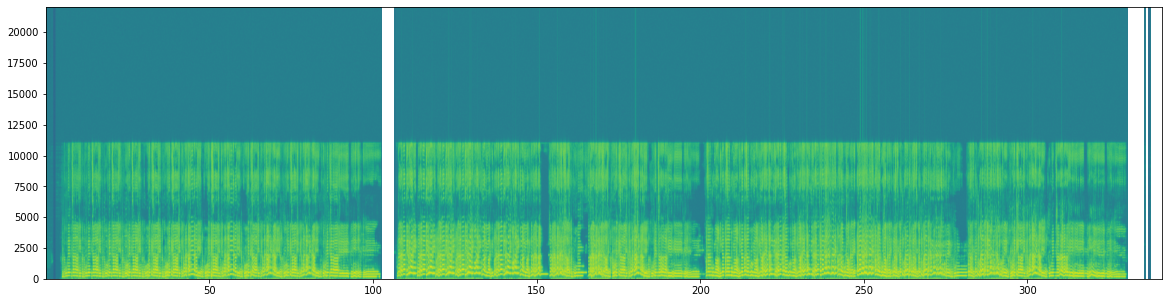

In [ ]:
song_to_test = Audio(path.format(songname = not_working[0].split('.mp3')[0]))

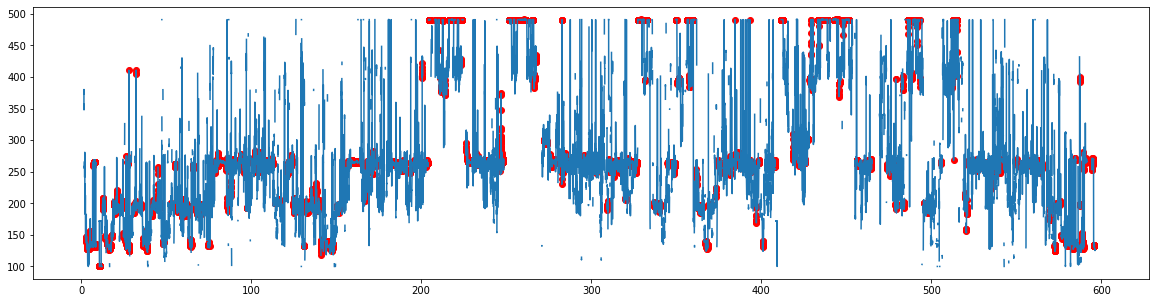

In [ ]:
plt.plot(song_to_test.time_axis,song_to_test.pitch)
plt.scatter(song_to_test.cpt,song_to_test.cpn,color = 'red')

In [ ]:
song_to_test.Sa_candidates

defaultdict(list, {'Ga3': 149.35712121212123, 'Ri2': 134.83785714285713})

song   - Govardana Giridhara.mp3
The Sa_candidates are :  defaultdict(<class 'list'>, {'Ri2': [137.77, 137.77, 138.14, 138.14, 140.66, 140.66, 154.22, 154.5, 154.5, 154.92, 155.62, 156.04], 'Ga3': [130.27, 130.27, 130.62, 130.27, 130.62, 130.86, 131.1, 130.27, 130.62, 130.86, 131.1, 131.45, 130.27, 130.62, 130.86, 131.1, 131.45, 131.93, 130.27, 130.62, 130.86, 131.1, 131.45, 131.93, 130.62, 130.86, 131.1, 131.45, 131.93, 132.52, 132.88, 133.36, 134.45, 134.69, 130.86, 131.1, 131.45, 131.93, 132.52, 132.88, 133.36, 134.45, 134.69, 131.45, 131.93, 132.52, 132.88, 133.36, 134.45, 134.69, 135.3, 132.52, 132.88, 133.36, 134.45, 134.69, 135.3, 133.36, 134.45, 134.69, 135.3, 133.36, 134.45, 134.69, 135.3, 134.45, 134.69, 135.3, 137.77, 134.45, 134.69, 135.3, 137.77, 138.14, 134.45, 134.69, 135.3, 137.77, 138.14, 135.3, 137.77, 138.14, 135.3, 137.77, 138.14, 137.77, 138.14, 137.77, 138.14, 140.66, 137.77, 138.14, 140.66, 138.14, 140.66]})
After remove outliers:  defaultdict(<class 'list'>, {'R

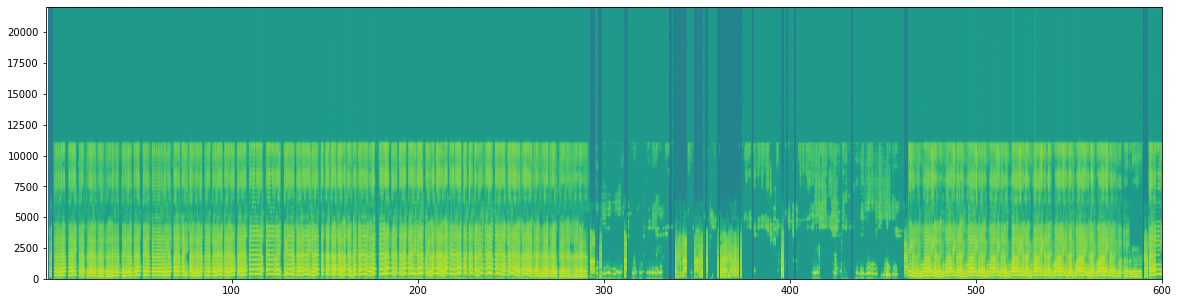

In [ ]:

for i in not_working[2:5]:
  print("song ",i)
  # with open("/content/drive/My Drive/AA/Music dataset/tonic_candi_finish_beta.txt","a") as finished_file:
  #   finished_file.write(i+'\n')
  song_to_test = Audio(path.format(songname = i.split('.mp3')[0]))
  print("TONIC IS ",song_to_test.tonic)
  # for j in compMusicTonicDetails:
  #   try:
  #     if compMusicTonicDetails[j]["songname"].split(".mp3")[0] == i:
  #       ourTonic[j] = compMusicTonicDetails[j]
  #       ourTonic[j]["Our Tonic"] = song_to_test.tonic
  #       json_object = json.dumps(ourTonic,indent = 4)
  #       with open("/content/drive/My Drive/AA/Music dataset/our_tonic_beta.json", "w") as out:
  #         out.write(json_object) 
  #       # comp_tonic = round(compMusicTonicDetails[j]["Tonic"],1)
  #       # comp_tonic_range = [round(i,1) for i in list(np.linspace(comp_tonic-5,comp_tonic+5,100))]
  #       # for l in song_to_test.tonic_candidates:
  #       #   if l in comp_tonic_range:
  #       #     print(i)
  #       #     with open("/content/drive/My Drive/AA/Music dataset/tonic_candi_1.txt","a") as working_file:
  #       #       working_file.write(i + '\n')
  #       #     k.append(i)
  #       #     break

  #   except (KeyError, FileNotFoundError):
  #     pass
  del song_to_test



In [ ]:
print(len(list(set(finished))),len(list(set(working))))

195 161


In [ ]:
len(all_songs)

195

In [ ]:
path = "/content/drive/My Drive/AA/Music dataset/Tonic_source_separation/{songname}/vocals.wav"

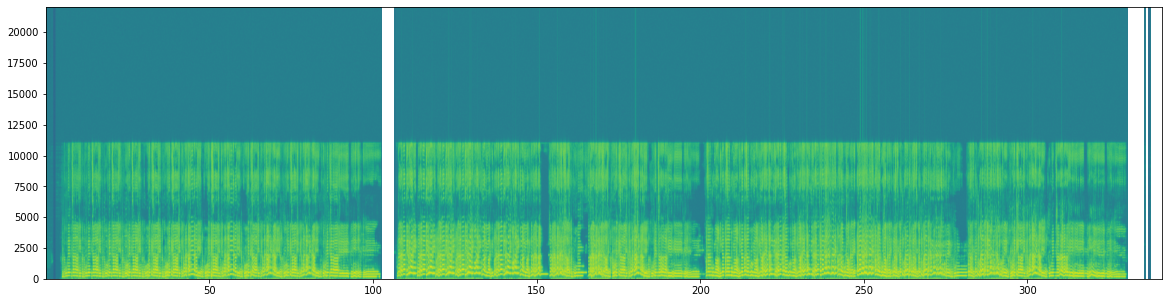

In [ ]:
%%capture
!pip install musdb
!pip install norbert
!pip install librosa
!pip install youtube-dl
!git clone https://github.com/sigsep/open-unmix-pytorch.git

In [ ]:
import torch
import numpy as np
import scipy
import librosa
import youtube_dl
import os
import soundfile as sf
from google.colab import files
from IPython.display import Audio, display

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
%cd open-unmix-pytorch/
import test

/content/open-unmix-pytorch


In [ ]:
audio, rate = librosa.load(
   "/content/drive/My Drive/Projects/AA/Music dataset/tonic_dataset_og/ - Anna Purne.mp3", 
    sr=44100,
    mono=False
)
display(Audio(audio, rate=rate))
estimates = test.separate(
    audio=audio.T,
    targets=['vocals'],
    residual_model=False,
    device=device,
    niter=1
)
for target, estimate in estimates.items():
    print(target)
    display(Audio(estimate.T, rate=rate))